In [143]:
import pandas as pd
import numpy as np

In [144]:
bogota = pd.read_csv('bogota.csv')
bogota

,FECHA_DIAGNOSTICO,CASO,CASOS_ACUMULADOS,RECUPERADO,RECUPERADOS_ACUMULADOS,FALLECIDOS,FALLECIDOS_ACUMULADOS
0,2020-03-06,1,1,1,1,0,0
1,2020-03-07,0,1,0,1,0,0
2,2020-03-08,0,1,0,1,0,0
3,2020-03-09,0,1,0,1,0,0
4,2020-03-10,2,3,2,3,0,0
...,...,...,...,...,...,...,...
678,2022-01-13,8075,1565063,168,1484374,5,27949
679,2022-01-14,7942,1573005,174,1484548,1,27950
680,2022-01-15,6754,1579759,235,1484783,7,27957
681,2022-01-16,5333,1585092,31,1484814,2,27959


In [145]:
bogota_cases = bogota.drop(['CASO', 'RECUPERADO', 'RECUPERADOS_ACUMULADOS','FALLECIDOS','FALLECIDOS_ACUMULADOS'],axis=1)
bogota_cases

,FECHA_DIAGNOSTICO,CASOS_ACUMULADOS
0,2020-03-06,1
1,2020-03-07,1
2,2020-03-08,1
3,2020-03-09,1
4,2020-03-10,3
...,...,...
678,2022-01-13,1565063
679,2022-01-14,1573005
680,2022-01-15,1579759
681,2022-01-16,1585092


In [146]:
bogota_cases.set_index('FECHA_DIAGNOSTICO', inplace = True)
bogota_cases

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2022-01-13,1565063
2022-01-14,1573005
2022-01-15,1579759


In [147]:
train = bogota_cases[:138]
train

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2020-07-17,63192
2020-07-18,65655
2020-07-19,68127


In [148]:
test = bogota_cases[138:138+14]
test

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-07-22,77437
2020-07-23,79880
2020-07-24,83604
2020-07-25,86717
2020-07-26,89002
2020-07-27,92710
2020-07-28,96653
2020-07-29,99736
2020-07-30,103354


In [149]:
from sklearn.preprocessing import MinMaxScaler

In [150]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [151]:
train_scaled =scaler.transform(train)
test_scaled = scaler.transform(test)

In [152]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [153]:
window_size= 5
n_features= 1
batch_size = 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train))
print("Total number of samples in the generated data = ", len(train_generator))

Total number of samples in the original training data =  138
Total number of samples in the generated data =  133


In [154]:
x_train, y_train = train_generator[0]
x_train.shape
y_train.shape

(1, 1)

In [155]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=window_size ,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(test))
print("Total number of sambles in the generated data", len(test_generator))

Total number of samples in the original training data =  14
Total number of sambles in the generated data 9


In [156]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError

In [157]:
model = Sequential()
model.add(LSTM(3, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
model.add(LSTM(3, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 3)              60        
                                                                 
 lstm_15 (LSTM)              (None, 3)                 84        
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________


In [165]:
history=model.fit(train_generator, validation_data = test_generator, epochs=5)

Epoch 1/5
133/133 [==============================] - 1s 7ms/step - loss: 0.0792 - root_mean_squared_error: 0.2814 - val_loss: 1.9182 - val_root_mean_squared_error: 1.3850
Epoch 2/5
133/133 [==============================] - 1s 7ms/step - loss: 0.0779 - root_mean_squared_error: 0.2790 - val_loss: 1.9035 - val_root_mean_squared_error: 1.3797
Epoch 3/5
133/133 [==============================] - 1s 6ms/step - loss: 0.0766 - root_mean_squared_error: 0.2768 - val_loss: 1.8897 - val_root_mean_squared_error: 1.3746
Epoch 4/5
133/133 [==============================] - 1s 6ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749 - val_loss: 1.8755 - val_root_mean_squared_error: 1.3695
Epoch 5/5
133/133 [==============================] - 1s 7ms/step - loss: 0.0745 - root_mean_squared_error: 0.2730 - val_loss: 1.8631 - val_root_mean_squared_error: 1.3650


In [167]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

In [168]:
import matplotlib.pyplot as plt

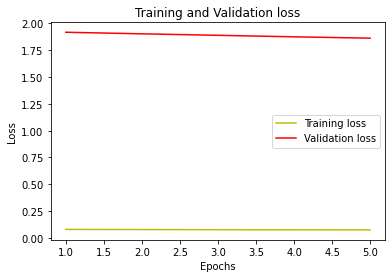

In [169]:
plt.plot(epochs, loss, 'y',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

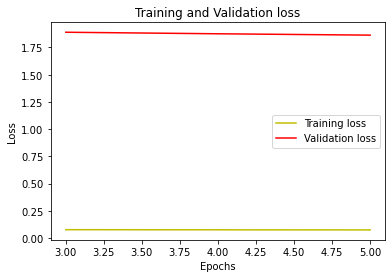

In [171]:
plt.plot(epochs[2:], loss[2:], 'y',label='Training loss')
plt.plot(epochs[2:], val_loss[2:], 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()